# Sentiment Analysis Chatbot using Amazon Product Reviews Dataset (All Beauty, 2013)

This notebook demonstrates the process of building a sentiment analysis model using the Amazon product reviews dataset (All Beauty, 2013) and integrating it with a chatbot using Streamlit.

## Load Dataset and Perform EDA

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import string

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load the dataset (Replace with actual file path)
# Example CSV file: 'amazon_reviews_all_beauty.csv'
df = pd.read_csv('/content/amazon_reviews_beauty_product.csv')

# Display the first few rows of the dataset
df.head()


,productId,title,price,userId,profileName,helpfulness,score,time,summary,text
0,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,A1FWT811DSZLC8,Heidi M,0/0,3.0,1.360368e+09,doesn't last,very light scent that doesn't last very long. ...
1,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,A1THE6V6O8ROD4,"Donna Mpaulin ""PURPLE RAVEN""",0/0,5.0,1.358467e+09,Smells divine.,"This is my second bottle of sheer freesia, I j..."
2,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,A176IQ7MVD3N6T,M. Avila,0/0,1.0,1.357085e+09,Very disappointed!,This perfume is just AWFUL! Smells nothing lik...
3,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,A34BDX4JVMG23Y,Kim M. Colt,0/0,5.0,1.326240e+09,Nice gift,This was a gift for my sister. It wowed her. S...
4,B000K5JBZU,Optimum Care Anti-Breakage Therapy Moisture Re...,5.99,A3UWJXJI7S3T05,PloveJ,01-Jan,5.0,1.351987e+09,TRULY MADE A DIFFERENCE!,I have been using this product for a couple ye...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252055 entries, 0 to 252054
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   productId    199998 non-null  object 
 1   title        199950 non-null  object 
 2   price        199998 non-null  object 
 3   userId       199998 non-null  object 
 4   profileName  199983 non-null  object 
 5   helpfulness  199998 non-null  object 
 6   score        199998 non-null  float64
 7   time         199998 non-null  float64
 8   summary      199997 non-null  object 
 9   text         199998 non-null  object 
dtypes: float64(2), object(8)
memory usage: 19.2+ MB


**This is amazon review dataset on beauty products from 2013. the dataset contains following columns**:

1.  productId: The ID of the product.
2.  title: The product's title.
3.  price: The product's price.
4.  userId: The ID of the user who reviewed.
5.  profileName: The user's profile name.
6.  helpfulness: The helpfulness score.
7.  score: The rating given by the user (this will be used for sentiment analysis).
8.  time: The timestamp of the review.
9.  summary: A short summary of the review.
10.  text: The full text of the review (this will be used for sentiment analysis).

# Data Preprocessing

In [4]:
df.drop(["userId", "profileName", "helpfulness", "time"], axis=1, inplace=True)

In [5]:
df.dropna(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199949 entries, 0 to 199997
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   productId  199949 non-null  object 
 1   title      199949 non-null  object 
 2   price      199949 non-null  object 
 3   score      199949 non-null  float64
 4   summary    199949 non-null  object 
 5   text       199949 non-null  object 
dtypes: float64(1), object(5)
memory usage: 10.7+ MB


In [7]:
# Let all the products having score >3 be classified as positive sentiment
# and products with score <3 be classified as negative sentiments.

df['sentiments'] = df['score'].apply(lambda x: 1 if x > 3 else 0)

In [8]:
df.head()

,productId,title,price,score,summary,text,sentiments
0,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,3.0,doesn't last,very light scent that doesn't last very long. ...,0
1,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,5.0,Smells divine.,"This is my second bottle of sheer freesia, I j...",1
2,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,1.0,Very disappointed!,This perfume is just AWFUL! Smells nothing lik...,0
3,B00064C0IU,Oscar Eau de Toilette for Women by Oscar de La...,24.19,5.0,Nice gift,This was a gift for my sister. It wowed her. S...,1
4,B000K5JBZU,Optimum Care Anti-Breakage Therapy Moisture Re...,5.99,5.0,TRULY MADE A DIFFERENCE!,I have been using this product for a couple ye...,1


# Exploratory Data Analysis

In [9]:
df.describe()

,score,sentiments
count,199949.000000,199949.000000
mean,4.162041,0.776608
std,1.332209,0.416520
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [10]:
df['sentiments'].value_counts()

,count
sentiments,
1,155282
0,44667


In [11]:
# Function to clean text data

stop_words = stopwords.words('english')

def clean_review(review):
  # Lowercase the text
  review = review.lower()

  # Removing punctuation
  review = ''.join([char for char in review if char not in string.punctuation])

  # Removing stopwords
  cleanreview = " ".join(word for word in review.
                          split() if word not in stop_words)
  return cleanreview

df['text'] = df['text'].apply(clean_review)

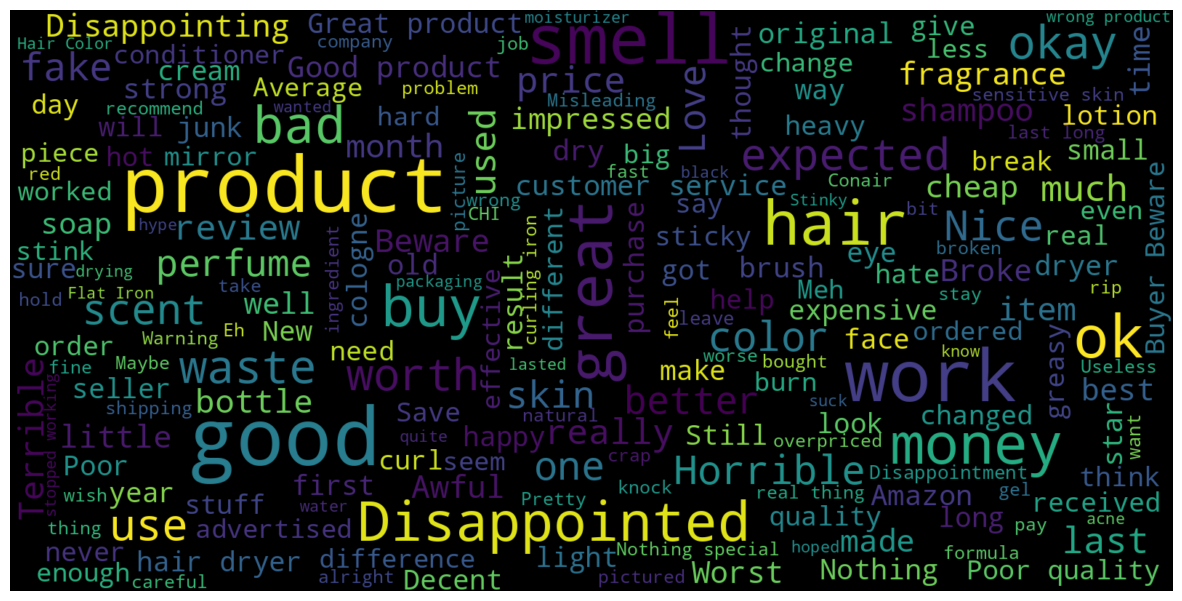

In [12]:
# Generating the wirdcloud
# Display the word count

consolidated_df = ' '.join(word for word in df['summary'][df['sentiments']==0].astype(str))
wordCloud = WordCloud(width =1600, height =800, random_state=21, max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated_df), interpolation='bilinear')
plt.axis('off')
plt.show()

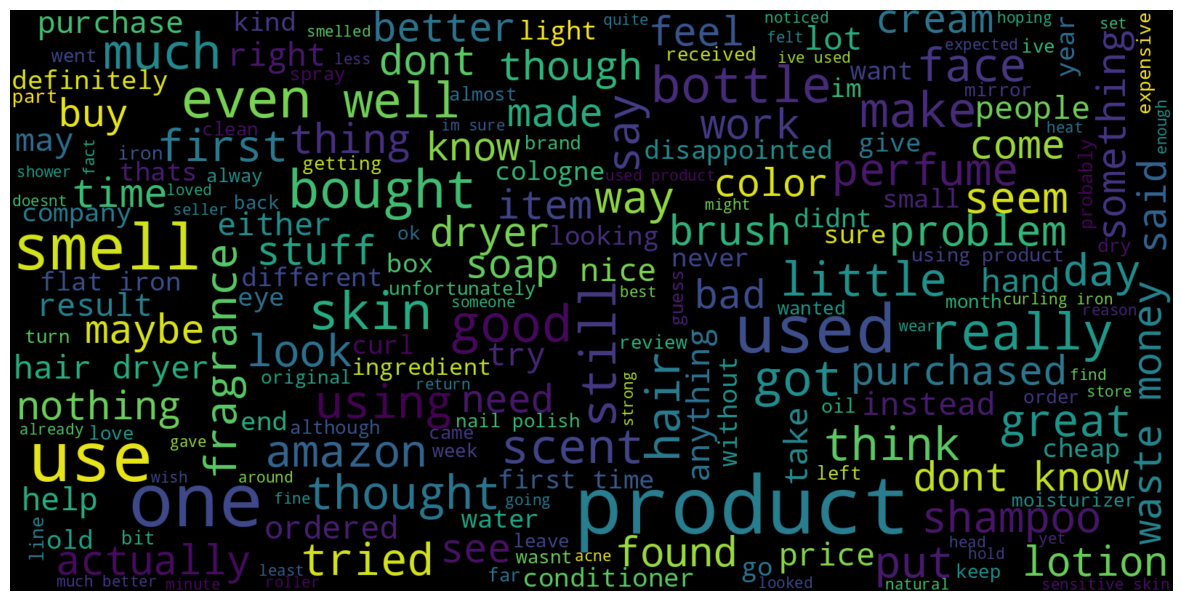

In [13]:
# Generating the wirdcloud
# Display the word count

consolidated_df = ' '.join(word for word in df['text'][df['sentiments']==0].astype(str))
wordCloud = WordCloud(width =1600, height =800, random_state=21, max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated_df), interpolation='bilinear')
plt.axis('off')
plt.show()

# Vectorized Text using TF-IDF

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['summary'], df['sentiments'], test_size =0.2, random_state=42)

# Vectorization using  TF-IDF
vectorizer = TfidfVectorizer(max_df=0.8, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Check the shape of the transformed data
X_train_tfidf.shape


(159959, 113083)

# Model Training  using Logistic  Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Training a Logistic Regression model
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names= ['Negative', 'Positive'])

print('Accuracy: ', accuracy)
print('Classification Report: ')
print(report)

Accuracy:  0.8834708677169293
Classification Report: 
              precision    recall  f1-score   support

    Negative       0.84      0.58      0.69      8892
    Positive       0.89      0.97      0.93     31098

    accuracy                           0.88     39990
   macro avg       0.87      0.78      0.81     39990
weighted avg       0.88      0.88      0.88     39990



# Saving Model and Vectorizer

In [16]:
import joblib

# Saving the trained model and vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfdif_vectorizer.pkl')

['tfdif_vectorizer.pkl']

# Chatbot Integration using IPython Widgets

In [17]:
# importing the ipywidget library
%%capture
!pip install ipywidgets

In [18]:
import ipywidgets as widgets
from IPython.display import display

In [19]:
# Load the model and vectorizer
model = joblib.load("/content/sentiment_model.pkl")
vectorizer = joblib.load("/content/tfdif_vectorizer.pkl")

In [22]:
# Fucntion to predict sentiment

def predict_sentiment(text):
  # preprocess the text using the same vectorizer used during training
  text_vector = vectorizer.transform([text])

  # Predict sentiment
  prediction = model.predict(text_vector)

  # Map prediction to sentiment labels
  if prediction ==1:
    return "Positive"
  elif prediction ==0:
    return "Negative"
  else:
    return "Neutral"

In [23]:

# IPywidget app interface
input_box = widgets.Text(placeholder='Enter your review')
output_box = widgets.Output()

def on_submit(change):
  output_box.clear_output()
  with output_box:
    sentiment = predict_sentiment(change.value)
    print(f"Sentiment: {sentiment}")

input_box.on_submit(on_submit)
display(input_box, output_box)

Text(value='', placeholder='Enter your review')

Output()